# SET UP LIBRARIES + CONSTANT

In [1]:
!pip install --upgrade pip
!pip install transformers datasets accelerate evaluate seqeval
!pip install peft bitsandbytes
!pip install git+https://github.com/unslothai/unsloth.git
!pip install --upgrade transformers
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 95.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'seqeval' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'seqeval'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=0aa767e58df0d8dea8ba711df472e42d5c5fb0cf28c0841c564083b6b8e15870
  Stored in directory: /root/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seq

In [2]:
import torch
print(torch.cuda.is_available())

True


In [3]:
MODEL_NAME = "microsoft/codebert-base"

# LOAD DATASET + PREPROCESSING

In [4]:
# load dataset
from datasets import load_dataset
ds = load_dataset("DaniilOr/SemEval-2026-Task13", 'A')
for split in ds:
    print(split, len(ds[split]))

README.md:   0%|          | 0.00/801 [00:00<?, ?B/s]

task_a/task_a_training_set_1.parquet:   0%|          | 0.00/203M [00:00<?, ?B/s]

task_a/task_a_validation_set.parquet:   0%|          | 0.00/40.5M [00:00<?, ?B/s]

task_a/task_a_test_set_sample.parquet:   0%|          | 0.00/593k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/500000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

train 500000
validation 100000
test 1000


In [5]:
import os
import shutil
import zipfile
from datasets import load_from_disk
from transformers import AutoTokenizer

zip_path = "/content/tokenized_dataset.zip"
temp_dir = "/content/temp_tokenized_data"

if os.path.exists(zip_path):
    print(f"Found existing {zip_path}")

    if os.path.exists(temp_dir):
      shutil.rmtree(temp_dir)
    os.makedirs(temp_dir)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)

    print(f"Loading dataset from {temp_dir}...")
    tokenized = load_from_disk(temp_dir)
    shutil.rmtree(temp_dir)
else:

    print(f"{zip_path} not found. Starting new tokenization process...")

    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

    def tokenize_batch(ex):
        return tokenizer(ex["code"], truncation=True, padding="max_length", max_length=512)

    tokenized = ds.map(tokenize_batch, batched=True, remove_columns=["code", "generator", "language"])
    tokenized = tokenized.rename_column("label", "labels")
    tokenized.set_format("torch")


    tokenized.save_to_disk(temp_dir)

    shutil.make_archive(base_name=zip_path.replace(".zip", ""), format='zip', root_dir=temp_dir, base_dir=".")
    shutil.rmtree(temp_dir)

print("Tokenization done!")

/content/tokenized_dataset.zip not found. Starting new tokenization process...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Map:   0%|          | 0/500000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/3 shards):   0%|          | 0/500000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Tokenization done!


In [6]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import LoraConfig, get_peft_model, TaskType

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

trainable params: 887,042 || all params: 125,534,212 || trainable%: 0.7066


In [7]:
# training
from transformers import TrainingArguments, Trainer
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    return metric.compute(predictions=preds, references=labels)

training_args = TrainingArguments(
    output_dir="/content/sem_eval_task13_lora",
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    num_train_epochs=3,
    fp16=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    eval_steps=2000,
    save_steps=2000,
    learning_rate=2e-4,
    weight_decay=0.05,
    logging_steps=10000,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir="/content/sem_eval_task13_logs",
    dataloader_num_workers=8,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.evaluate()

model.save_pretrained("/content/sem_eval_task13_lora_adapter")

/tmp/ipython-input-3478302666.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: divyaavuti-da (divyaavuti-da-purdue-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.025254,0.991250
2,No log,0.022085,0.992470
3,No log,0.019845,0.993050


              precision    recall  f1-score   support

           0     0.7984    0.1326    0.2274       777
           1     0.2262    0.8834    0.3601       223

    accuracy                         0.3000      1000
   macro avg     0.5123    0.5080    0.2938      1000
weighted avg     0.6708    0.3000    0.2570      1000



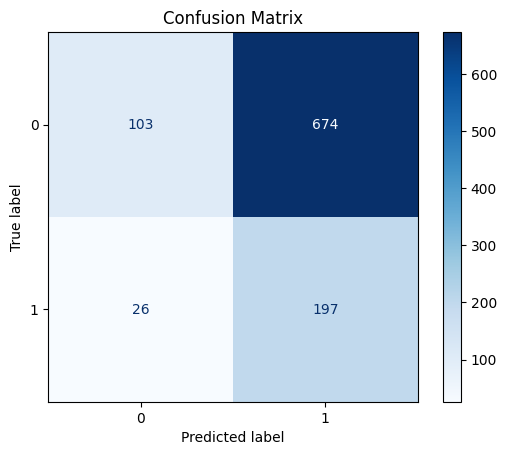

In [10]:
# test/evaluate on test split and compute precision/recall/F1
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

model.eval()
dataloader = torch.utils.data.DataLoader(tokenized["test"], batch_size=32)
y_true, y_pred = [], []

for batch in dataloader:
    inputs = {k: v.cuda() if torch.cuda.is_available() else v for k, v in batch.items() if k != "labels"}
    labels = batch["labels"].numpy()
    with torch.no_grad():
        outputs = model(**inputs)
    preds = outputs.logits.argmax(-1).cpu().numpy()
    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

# Print classification report
print(classification_report(y_true, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import shutil
import os

folders_to_zip = [
    # "/content/sem_eval_task13_logs",
    # "/content/sem_eval_task13_lora",
    # "/content/wandb",
    "/content/tokenized_dataset"
]

for folder_path in folders_to_zip:
    if os.path.exists(folder_path):
        zip_filename = os.path.basename(folder_path) + ".zip"
        shutil.make_archive(zip_filename.replace(".zip", ""), 'zip', folder_path)
        print(f"Created {zip_filename}")
    else:
        print(f"Folder not found: {folder_path}")

Folder not found: /tokenized_dataset
